In [1]:
%matplotlib inline
import math
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import plotly.express as px

import warnings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [163]:
df = pd.read_csv('/content/drive/MyDrive/1_Thinkful_Colab_Notebooks/csv files/new_Creditcard_Churners.csv')

In [4]:
df.head(4)

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Gender,EDUCATION_College,EDUCATION_Graduate,EDUCATION_High School,EDUCATION_Post-Graduate,EDUCATION_Uneducated,INCOME_$40K - $60K,INCOME_$60K - $80K,INCOME_$80K - $120K,INCOME_Less than $40K,CARD_Blue,CARD_Gold,CARD_Silver,MARITAL_Divorced,MARITAL_Married,MARITAL_Single
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0


In [ ]:
df.shape

(10127, 31)

##Splt X and Y

In [164]:
x = df.drop(['Attrition_Flag'],axis=1)
Y = df['Attrition_Flag']

##Normalizing and Scaling features

In [165]:
#Normalize and Scale the variables
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
#convert back to dataframe
X = pd.DataFrame(x_scaled, columns=x.columns)
X.head(2)

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender,EDUCATION_College,EDUCATION_Graduate,EDUCATION_High School,EDUCATION_Post-Graduate,EDUCATION_Uneducated,INCOME_$40K - $60K,INCOME_$60K - $80K,INCOME_$80K - $120K,INCOME_Less than $40K,CARD_Blue,CARD_Gold,CARD_Silver,MARITAL_Divorced,MARITAL_Married,MARITAL_Single
0,-0.165406,0.503368,0.384621,0.763943,-1.327136,0.492404,0.446622,-0.473422,0.488971,2.623494,-0.959707,-0.973895,3.834003,-0.775882,-1.059956,-0.333388,-0.920865,2.007685,-0.231708,-0.414857,-0.463363,2.494645,-0.422675,-0.925636,0.270611,-0.107644,-0.240794,-0.282405,1.077338,-0.798507
1,0.333570,2.043199,1.010715,1.407306,-1.327136,-0.411616,-0.041367,-0.366667,-0.008486,3.563293,-0.916433,-1.357340,12.608573,-0.616276,0.943436,-0.333388,1.085935,-0.498086,-0.231708,-0.414857,-0.463363,-0.400859,-0.422675,1.080338,0.270611,-0.107644,-0.240794,-0.282405,-0.928214,1.252337


In [166]:
#drop the unimportant features. This is an iteration based on feature importance obtain 
#from running initial runing of the Gradient Boost model
X = X.drop(['Total_Trans_Amt', 'Months_on_book', 'MARITAL_Divorced', 'MARITAL_Married', 
            'INCOME_Less than $40K', 'INCOME_$40K - $60K', 'INCOME_$60K - $80K', 
            'INCOME_$80K - $120K', 'EDUCATION_Uneducated', 'EDUCATION_High School', 'EDUCATION_Graduate', 
            'EDUCATION_College', 'EDUCATION_Post-Graduate', 'CARD_Silver', 'CARD_Gold'],  axis=1)
X.head(2)
X_sorted = ['Total_Trans_Ct', 'Total_Revolving_Bal', 'Months_Inactive_12_mon', 'Total_Ct_Chng_Q4_Q1',
            'Total_Relationship_Count', 'Contacts_Count_12_mon', 'Total_Amt_Chng_Q4_Q1', 
            'Avg_Utilization_Ratio', 'Credit_Limit', 'Gender', 'Dependent_count', 'Customer_Age', 
            'Avg_Open_To_Buy', 'MARITAL_Single', 'CARD_Blue']
X = pd.DataFrame(X,columns=X_sorted)

In [167]:
X.head(3)

,Total_Trans_Ct,Total_Revolving_Bal,Months_Inactive_12_mon,Total_Ct_Chng_Q4_Q1,Total_Relationship_Count,Contacts_Count_12_mon,Total_Amt_Chng_Q4_Q1,Avg_Utilization_Ratio,Credit_Limit,Gender,Dependent_count,Customer_Age,Avg_Open_To_Buy,MARITAL_Single,CARD_Blue
0,-0.973895,-0.473422,-1.327136,3.834003,0.763943,0.492404,2.623494,-0.775882,0.446622,-1.059956,0.503368,-0.165406,0.488971,-0.798507,0.270611
1,-1.357340,-0.366667,-1.327136,12.608573,1.407306,-0.411616,3.563293,-0.616276,-0.041367,0.943436,2.043199,0.333570,-0.008486,1.252337,0.270611
2,-1.911206,-1.426858,-1.327136,6.807864,0.120579,-2.219655,8.367214,-0.997155,-0.573698,-1.059956,0.503368,0.583058,-0.445658,-0.798507,0.270611


##Dealing with imbalanced data. To balance this dataset, I will use the SMOTE oversampling method.

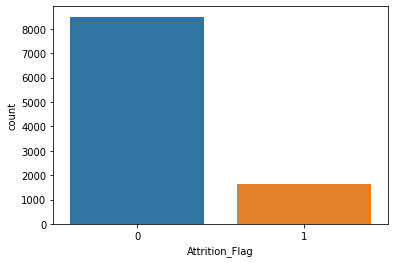

In [168]:
#check initial distribution
sns.countplot(x=Y)

In [169]:
from imblearn.over_sampling import SMOTE

#apply the smote over-sampling method.
smote = SMOTE(sampling_strategy='minority', random_state=68)
X_sm, y_sm = smote.fit_resample(X,Y)
X_sm = pd.DataFrame(X_sm, columns=X.columns)
#y_sm = pd.DataFrame(y_sm, columns=['Attrition_Flag'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



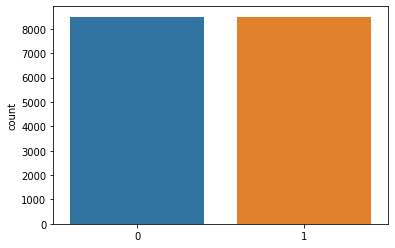

In [170]:
sns.countplot(x=y_sm)

##The dataset is now balanced.

#**---------------------Step 3: Model Creation and Performance Evaluation-------------------**

---




In [172]:
#split my dataset 70/30
X_train,X_test,y_train,y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state = 68, stratify=y_sm)

##***Hyper-parameter tuning and Cross-validation of various models***

In [173]:
#define a function that plots confusion matrix
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##***Using Logistic Regression***

In [105]:
#hyperparameter tuning using Gridsearch
lr_cv = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=10000, penalty='l2', random_state=68), 
                  {'C':[.2, .7, 1.3, 1.4]}, cv=5, return_train_score = True)
#fit model
lr_cv.fit(X_train, y_train)

#return output as a dataframe
lr_cv_df = pd.DataFrame(lr_cv.cv_results_)
lr_cv_df[['param_C', 'mean_train_score',	'std_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_C,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
0,0.2,0.835756,0.001462,0.834874,0.005989,1
1,0.7,0.835840,0.001468,0.834790,0.005915,2
2,1.3,0.835756,0.001410,0.834790,0.005915,2
3,1.4,0.835756,0.001410,0.834790,0.005915,2


In [106]:
print('Best parameters: \n {}'.format(lr_cv.best_params_))
print('Best score: \n {}'.format(lr_cv.best_score_))

Best parameters: 
 {'C': 0.2}
Best score: 
 0.834873949579832


In [184]:
#Building the Logistics Regression model with the best parameters found
lr = LogisticRegression(solver='lbfgs', max_iter=10000, penalty='l2', random_state=68, C=0.2)
#fit model
lr.fit(X_train, y_train)
#accuracy score of train model and round to 3 dp
print('Accuracy score train model: {}'.format(np.round(lr.score(X_train, y_train), decimals=3)))

#make prediction
y_preds = lr.predict(X_test)
y_preds = np.round(y_preds, decimals=3)
print('Classification Report: \n', classification_report(y_test, y_preds,
                                    target_names=['Existing Customers', 'Churned Customers']))

Accuracy score train model: 0.839
Classification Report: 
                     precision    recall  f1-score   support

Existing Customers       0.83      0.84      0.84      2550
 Churned Customers       0.84      0.83      0.83      2550

          accuracy                           0.83      5100
         macro avg       0.83      0.83      0.83      5100
      weighted avg       0.83      0.83      0.83      5100



Confusion matrix, without normalization


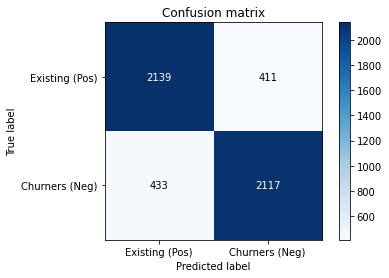

In [108]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,['Existing (Pos)','Churners (Neg)'],False)

In [118]:
#get the coefficients
#log transformed coeffs
coeffs_log = lr.coef_
print(coeffs_log)
#get odds ratio
coeffs = np.exp(coeffs_log)
print('coefficient in odds ratio {}'.format(coeffs))

[[-1.66697312 -0.54875539  0.57196692 -0.59587828 -0.77364454  0.54919903
   0.01293133 -0.17884128 -0.06241865  0.2308626   0.15905285 -0.12213986
  -0.01320917  0.19574391 -0.20457885]]
coefficient in odds ratio [[0.18881773 0.57766833 1.77174852 0.55107835 0.46132867 1.7318653
  1.0130153  0.83623861 0.93948949 1.25968615 1.17239991 0.88502458
  0.98687769 1.2162154  0.81499048]]


In [121]:
intercept = lr.intercept_
np.exp(intercept)

array([0.29264542])

Equation is:
##Y = -1.22 - 1.67**Total_Trans_Ct** - 0.549**Total_Revolving_Bal** + 0.572**Months_Inactive_12_mon** - 0.596**Total_Ct_Chng_Q4_Q1** - 0.774**Total_Relationship_Count** + 0.549**Contacts_Count_12_mon** + 0.0129**Total_Amt_Chng_Q4_Q1** - 0.179**Avg_Utilization_Ratio** - 0.0624**Credit_Limit** + 0.2308626**Gender** + 0.159**Dependent_count** - 0.122**Customer_Age** - 0.0132**Avg_Open_To_Buy** + 0.196**MARITAL_Single** - 0.205**CARD_Blue**

Equation (Odds ratio):
##Y = 0.293 + 0.189**Total_Trans_Ct** + 0.578**Total_Revolving_Bal** + 1.77**Months_Inactive_12_mon** + 0.551**Total_Ct_Chng_Q4_Q1** + 0.461**Total_Relationship_Count** + 1.73**Contacts_Count_12_mon** + 1.01**Total_Amt_Chng_Q4_Q1** + 0.836**Avg_Utilization_Ratio** + 0.939**Credit_Limit** + 1.26**Gender** + 1.17**Dependent_count** + 0.885**Customer_Age** + 0.987**Avg_Open_To_Buy** + 1.22**MARITAL_Single** + 0.815**CARD_Blue**

##***Using KNN Classifier***

In [ ]:
#hyperparameter tuning using Gridsearch
knn = GridSearchCV(KNeighborsClassifier(weights= 'distance'),
                   {'n_neighbors':[1,3,5,8]},cv=5, return_train_score=True)
#fit model
knn.fit(X_train,y_train)

#return output as a dataframe
knn_df = pd.DataFrame(knn.cv_results_)
knn_df[['param_n_neighbors', 'mean_train_score',
        'std_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
0,1,1.0,0.0,0.923782,0.004926,1
1,2,1.0,0.0,0.923782,0.004926,1
2,5,1.0,0.0,0.885630,0.006251,4
3,7,1.0,0.0,0.880000,0.006882,5
4,8,1.0,0.0,0.886639,0.007038,3
5,10,1.0,0.0,0.879244,0.007723,6


In [ ]:
print('Best parameters: \n {}'.format(knn.best_params_))
print('Best score: \n {}'.format(knn.best_score_))

Best parameters: 
 {'n_neighbors': 1}
Best score: 
 0.9237815126050422


In [183]:
#training KNN model with the best parameters
neighbors = KNeighborsClassifier(n_neighbors=2, weights= 'distance')
#fit model
neighbors.fit(X_train, y_train)
#accuracy score of train model
print('Accuracy score train model: {}'.format(neighbors.score(X_train, y_train)))

#make prediction
y_preds_knn = neighbors.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_preds_knn,
                                    target_names=['Existing Customers', 'Churned Customers']))

Accuracy score train model: 1.0
Classification Report: 
                     precision    recall  f1-score   support

Existing Customers       0.99      0.90      0.94      2550
 Churned Customers       0.91      0.99      0.95      2550

          accuracy                           0.95      5100
         macro avg       0.95      0.95      0.95      5100
      weighted avg       0.95      0.95      0.95      5100



Confusion matrix, without normalization


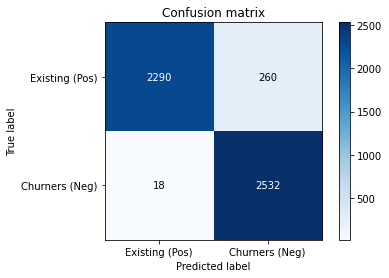

In [32]:
cm = confusion_matrix(y_test, y_preds_knn)
plot_confusion_matrix(cm,['Existing (Pos)','Churners (Neg)'],False)

##***Using SVM Classifier***

In [ ]:
#hyperparameter tuning using Gridsearch
svc_cv = GridSearchCV(svm.SVC(gamma='auto', kernel= 'rbf', random_state= 68),
                      {'C': [10,20]}, cv=5, return_train_score=True)
#fit model
svc_cv.fit(X_train, y_train)

#return output as a dataframe
svc_cv_df = pd.DataFrame(svc_cv.cv_results_)
svc_cv_df[["param_C", 'mean_train_score',	'std_train_score',
           'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_C,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
0,10,0.986176,0.000413,0.959160,0.004051,2
1,20,0.991639,0.000236,0.960252,0.002665,1


In [178]:
#Building the SVM model with the best parameters found
svc = svm.SVC(gamma='auto', C = 20, kernel='rbf', random_state=68)
#fit model
svc.fit(X_train, y_train)
#accuracy score of train model
print('Accuracy score train model: {}'.format(svc.score(X_train, y_train)))

#make prediction
y_preds_svc = svc.predict(X_test)
y_preds_svc = np.round(y_preds_svc, decimals=3)
print('Classification Report: \n', classification_report(y_test,y_preds_svc,
                                    target_names=['Existing Customers', 'Churned Customers']))

Accuracy score train model: 0.979327731092437
Classification Report: 
                     precision    recall  f1-score   support

Existing Customers       0.97      0.93      0.95      2550
 Churned Customers       0.93      0.97      0.95      2550

          accuracy                           0.95      5100
         macro avg       0.95      0.95      0.95      5100
      weighted avg       0.95      0.95      0.95      5100



Confusion matrix, without normalization


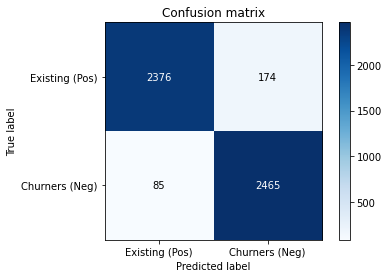

In [162]:
cm = confusion_matrix(y_test, y_preds_svc)
plot_confusion_matrix(cm,['Existing (Pos)','Churners (Neg)'],False)

##***Using Decision Tree Classifier***

In [ ]:
#hyperparameter tuning using Gridsearch
dtc_cv = GridSearchCV(tree.DecisionTreeClassifier(criterion='entropy', random_state = 68), 
                   {'max_depth':[5,6,7], 'max_features':[3,4,5,6]}, cv=5, return_train_score=True)
dtc_cv.fit(X_train, y_train)
#return output as a dataframe
dtc_cv_df = pd.DataFrame(dtc_cv.cv_results_)
dtc_cv_df[["param_max_depth", "param_max_features", 'mean_train_score',
           'std_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_max_depth,param_max_features,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
0,5,3,0.742626,0.048543,0.738655,0.053668,12
1,5,4,0.809727,0.016353,0.802269,0.023134,10
2,5,5,0.881492,0.013401,0.873361,0.021031,6
3,5,6,0.877269,0.010091,0.876218,0.008756,5
4,6,3,0.794433,0.041952,0.779832,0.043454,11
5,6,4,0.826765,0.013150,0.825798,0.015952,8
6,6,5,0.888445,0.006327,0.876891,0.006158,4
7,6,6,0.887395,0.013270,0.881681,0.013371,3
8,7,3,0.843088,0.014790,0.827563,0.016969,7
9,7,4,0.839664,0.027970,0.825630,0.027291,9


In [ ]:
print('Best parameters: \n {}'.format(dtc_cv.best_params_))
print('Best score: \n {}'.format(dtc_cv.best_score_))

Best parameters: 
 {'max_depth': 7, 'max_features': 6}
Best score: 
 0.8921848739495799


In [180]:
dtc = tree.DecisionTreeClassifier(criterion='entropy', max_features=6, max_depth=7, random_state = 68)
#fit model
dtc.fit(X_train, y_train)
#accuracy score of train model
print('Accuracy score train model: {}'.format(dtc.score(X_train, y_train)))

#make prediction
y_preds_dtc = dtc.predict(X_test)
y_preds_dtc = np.round(y_preds, decimals=3)
print('Classification Report: \n', classification_report(y_test, y_preds_dtc,
                                    target_names=['Existing Customers', 'Churned Customers']))

Accuracy score train model: 0.8932773109243698
Classification Report: 
                     precision    recall  f1-score   support

Existing Customers       0.83      0.84      0.84      2550
 Churned Customers       0.84      0.83      0.83      2550

          accuracy                           0.83      5100
         macro avg       0.83      0.83      0.83      5100
      weighted avg       0.83      0.83      0.83      5100



Confusion matrix, without normalization


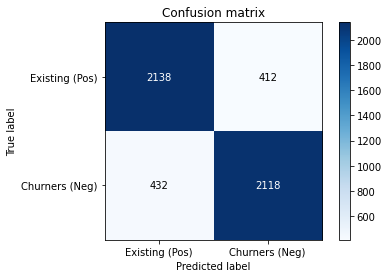

In [36]:
cm = confusion_matrix(y_test, y_preds_dtc)
plot_confusion_matrix(cm,['Existing (Pos)','Churners (Neg)'],False)

In [ ]:
# A convenience for displaying visualizations
from IPython.display import Image

# Packages for rendering the tree
import pydotplus
import graphviz

# Render the tree
dot_data = tree.export_graphviz(
    dtc, out_file=None,
    feature_names=X.columns,
    class_names=['Not Churned','Churned'],
    filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

##***Using Random Forest Classifier***

In [175]:
#hyperparameter tuning using Gridsearch
rfc = GridSearchCV(RandomForestClassifier(criterion='entropy', random_state=68), 
                   {'n_estimators': [100], 'max_depth': [6,7,8], 'max_features': [4,5,6]}, cv=5, return_train_score=True)
#fit model
rfc.fit(X_train, y_train)
#return output as a dataframe
rfc_df = pd.DataFrame(rfc.cv_results_)
rfc_df[["param_max_depth", "param_max_features", 'mean_train_score',
        'std_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_max_depth,param_max_features,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
0,6,4,0.924349,0.001881,0.915294,0.002820,7
1,6,5,0.922668,0.001508,0.911513,0.004491,9
2,6,6,0.923718,0.001489,0.912605,0.004486,8
3,7,4,0.938613,0.001242,0.924874,0.003657,4
4,7,5,0.938193,0.001862,0.924454,0.003715,6
5,7,6,0.939643,0.000922,0.924790,0.005712,5
6,8,4,0.950798,0.001765,0.932521,0.002795,1
7,8,5,0.952101,0.000737,0.932437,0.004749,2
8,8,6,0.952857,0.000931,0.930756,0.005436,3


In [176]:
print('Best parameters: \n {}'.format(rfc.best_params_))
print('Best score: \n {}'.format(rfc.best_score_))

Best parameters: 
 {'max_depth': 8, 'max_features': 4, 'n_estimators': 100}
Best score: 
 0.9325210084033614


In [177]:
#Building the Random Forest model with the best parameters found
rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=7, max_features=6, random_state=68)
#fit model
rf.fit(X_train, y_train)
#accuracy score of train model
print('Accuracy score train model: {}'.format(rf.score(X_train, y_train)))

#make prediction
y_preds_rf = rf.predict(X_test)
y_preds_rf = np.round(y_preds_rf, decimals=3)
print('Classification Report: \n', classification_report(y_test, y_preds_rf, 
                                     target_names=['Existing Customers', 'Churned Customers']))

Accuracy score train model: 0.9346218487394958
Classification Report: 
                     precision    recall  f1-score   support

Existing Customers       0.92      0.92      0.92      2550
 Churned Customers       0.92      0.92      0.92      2550

          accuracy                           0.92      5100
         macro avg       0.92      0.92      0.92      5100
      weighted avg       0.92      0.92      0.92      5100



Confusion matrix, without normalization


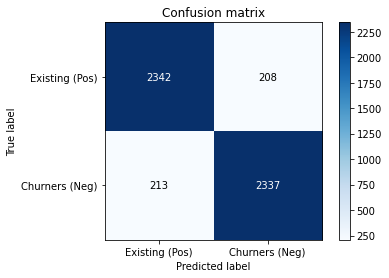

In [179]:
cm = confusion_matrix(y_test, y_preds_rf)
plot_confusion_matrix(cm,['Existing (Pos)','Churners (Neg)'],False)

##***Using Gradient Boosting Classifier***

In [40]:
#hyperparameter tuning using Gridsearch
params = {'n_estimators': 100, 'loss': 'deviance'}
gbc_cv = GridSearchCV(ensemble.GradientBoostingClassifier(**params), 
                   {'max_depth': [2,3], 'max_features': [2,3,4,5,6]}, cv=5, return_train_score=True)
#fit model
gbc_cv.fit(X_train, y_train)

#return output as a dataframe
gbc_cv_df = pd.DataFrame(gbc_cv.cv_results_)
gbc_cv_df[["param_max_depth", "param_max_features", 'mean_train_score',
        'std_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_max_depth,param_max_features,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
0,2,2,0.916618,0.001929,0.912185,0.004686,10
1,2,3,0.918929,0.001296,0.914538,0.004379,9
2,2,4,0.923151,0.002197,0.918655,0.003838,8
3,2,5,0.926071,0.001957,0.920504,0.003115,7
4,2,6,0.928508,0.001772,0.923529,0.006135,6
5,3,2,0.937815,0.000846,0.930168,0.002663,5
6,3,3,0.942689,0.000646,0.933697,0.004230,4
7,3,4,0.945924,0.000607,0.937983,0.004615,3
8,3,5,0.948424,0.001817,0.940084,0.002718,2
9,3,6,0.949958,0.001745,0.940168,0.003884,1


In [43]:
print('Best parameters: \n {}'.format(gbc_cv.best_params_))
print('Best score: \n {}'.format(gbc_cv.best_score_))

Best parameters: 
 {'max_depth': 3, 'max_features': 6}
Best score: 
 0.9401680672268908


In [156]:
#Building the Gradient Boosting model with the best parameters found
params = {'n_estimators': 100,'loss': 'deviance','max_depth': 3, 
                           'max_features': 6, 'random_state': 68}
gbc = ensemble.GradientBoostingClassifier(**params)
#fit model
gbc.fit(X_train, y_train)
#accuracy score of train model
print('Accuracy score train model: {}'.format(gbc.score(X_train, y_train)))

#make prediction
y_preds_gbc = gbc.predict(X_test)
y_preds_gbc = np.round(y_preds_gbc, decimals=4)
print('Classification Report: \n', classification_report(y_test, y_preds_gbc,
                    target_names=['Existing Customers', 'Churned Customers']))

Accuracy score train model: 0.9496638655462185
Classification Report: 
                     precision    recall  f1-score   support

Existing Customers       0.94      0.95      0.94      2550
 Churned Customers       0.95      0.94      0.94      2550

          accuracy                           0.94      5100
         macro avg       0.94      0.94      0.94      5100
      weighted avg       0.94      0.94      0.94      5100



Confusion matrix, without normalization


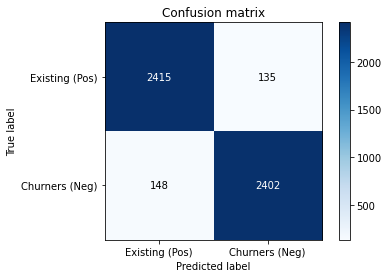

In [157]:
cm = confusion_matrix(y_test, y_preds_gbc)
plot_confusion_matrix(cm,['Existing (Pos)','Churners (Neg)'],False)

The SVM model and the ensemble models (Random Forest and Gradient Boosting classifiers) gave the best accuracy, precision, recall and F1 scores. I tried different parameters to see which gives the best accuracy. 

For a churn prediction, recall is more important. This is because if I predicted customers to be churners, and they don't churn, the bank doesn't lose much, however, if I predicted customers to be non-churners, and they churn, the bank loses customers. So what is needed is a model with lower false negative predictions.

The SVM model had the lowest false negatives, therefore the best recall of 98% and the best accuracy as well of 96%. That's the model I will go with.

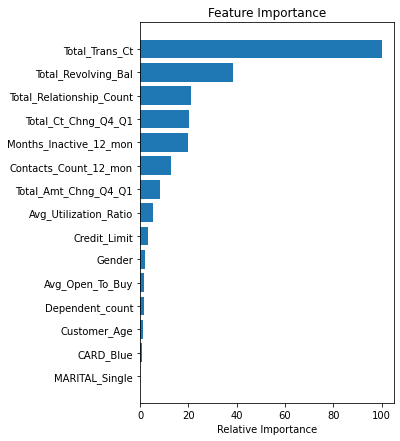

In [160]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,7))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

The 3 most important features are `Total_Trans_Ct`, `Total_Trans_Amt` and `Total_Revolving_Bal`. Other highly important features are `Months_Inactive_12_mon`, `Total_Relationship_Count`, `Total_CT_Chng_Q4_Q1`, `Contacts_Count_12_mon`, `Ag_Utilization_Ratio`, `Total_Amount_Chng_Q4_Q1`.